This is a part of series I am writing, named "**Speed Up Your Algorithms**". 

Here is the list of posts with files I have written:
[Github-SpeedUpYourAlgorithms](https://github.com/PuneetGrov3r/MediumPosts/tree/master/SpeedUpYourAlgorithms)

# Initial

### Torch, Torchvision:

In [0]:
!cat /usr/local/cuda/version.txt

CUDA Version 9.2.148


In [0]:
!pip install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip install torchvision

### Pycuda:

In [0]:
# https://medium.com/@iphoenix179/running-cuda-c-c-in-jupyter-or-how-to-run-nvcc-in-google-colab-663d33f53772
# https://developer.nvidia.com/cuda-90-download-archive?target_os=Linux&target_arch=x86_64&target_distro=Ubuntu&target_version=1704&target_type=deblocal
!apt update -qq;
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!mv cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb  
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update -qq;
!apt-get install cuda gcc-5 g++-5 -y -qq;
!ln -s /usr/bin/gcc-5 /usr/local/cuda/bin/gcc;
!ln -s /usr/bin/g++-5 /usr/local/cuda/bin/g++;
#!apt install cuda-9.2;

In [0]:
# http://alisonrowland.com/articles/installing-pycuda-via-pip
# https://codeyarns.com/2015/07/31/pip-install-error-with-pycuda/
import os
PATH = os.environ["PATH"]
os.environ["PATH"] = "/usr/local/cuda-9.2/bin:/usr/local/cuda/bin:" + PATH
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda/lib64"
os.environ["CUDA_ROOT"] = "/usr/local/cuda/"

In [0]:
!pip -q install --ignore-installed pycuda

# Import

In [0]:
import torchvision
import torch
import numpy as np
import pandas as pd
from torch import nn

import matplotlib.pyplot as plt

In [0]:
import pycuda.driver as cuda
cuda.init()

# 2. How to check the availability of cuda?

In [0]:
torch.cuda.is_available() # We are on GPU instance, so cuda is already installed.

True

# 3. How to get more info on your cuda devices?

In [0]:
torch.cuda.current_device() # Get Id of current cuda device

0

In [0]:
cuda.Device(0).name() # get name of device using pycuda

'Tesla K80'

In [0]:
torch.cuda.get_device_name(0) # or using torch

'Tesla K80'

In [0]:
# Simple class for getting info on all cuda compatible devices
import pycuda.autoinit

class aboutCudaDevices():
    def __init__(self):
        pass
    
    def num_devices(self):
        """Return number of devices connected."""
        return cuda.Device.count()
    
    def devices(self):
        """Get info on all devices connected."""
        num = cuda.Device.count()
        print("%d device(s) found:"%num)
        for i in range(num):
            print(cuda.Device(i).name(), "(Id: %d)"%i)
            
    def mem_info(self):
        """Get available and total memory of all devices."""
        available, total = cuda.mem_get_info()
        print("Available: %.2f GB\nTotal:     %.2f GB"%(available/1e9, total/1e9))
        
    def attributes(self, device_id=0):
        """Get attributes of device with device Id = device_id"""
        return cuda.Device(device_id).get_attributes()
    
    def __repr__(self):
        """Class representation as number of devices connected and about them."""
        num = cuda.Device.count()
        string = ""
        string += ("%d device(s) found:\n"%num)
        for i in range(num):
            string += ( "    %d) %s (Id: %d)\n"%((i+1),cuda.Device(i).name(),i))
            string += ("          Memory: %.2f GB\n"%(cuda.Device(i).total_memory()/1e9))
        return string

# You can print output just by typing its name (__repr__):
aboutCudaDevices()

1 device(s) found:
    1) Tesla K80 (Id: 0)
          Memory: 12.00 GB

In [0]:
# Lets check how much memory is allocated:
torch.cuda.memory_allocated()

0

In [0]:
# Let allocate some arrays to GPU:
mat_a = torch.cuda.FloatTensor((100., 100.))
mat_a

tensor([100., 100.], device='cuda:0')

In [0]:
# Lets check how muc memory is allocated now:
torch.cuda.memory_allocated()

512

In [0]:
# Memory used by Cache Allocator:
torch.cuda.memory_cached()

1048576

In [0]:
# These memory methods are only available for GPUs. And that's where they are actually needed.

# 4. How to store Tensors and run Models on GPU?

In [0]:
# For storing something on CPU:
Mat_cpu = torch.FloatTensor([1., 2.])
Mat_cpu

tensor([1., 2.])

In [0]:
# To put this on GPU:
Mat_gpu = Mat_cpu.cuda()
Mat_gpu, Mat_cpu

(tensor([1., 2.], device='cuda:0'), tensor([1., 2.]))

In [0]:
# Or you could have done:
Mat_gpu2 = torch.cuda.FloatTensor([1., 2.])
Mat_gpu2

tensor([1., 2.], device='cuda:0')

In [0]:
# Putting Model on GPU:
sq = nn.Sequential(
         nn.Linear(20, 20),
         nn.ReLU(),
         nn.Linear(20, 4),
         nn.Softmax()
)

In [0]:
model = sq.cuda()

In [0]:
# To check if model is on GPU:
# From the discussions here: discuss.pytorch.org/t/how-to-check-if-model-is-on-cuda
next(model.parameters()).is_cuda

True

# CPU vs GPU

In [0]:
model_cpu = nn.Sequential(
         nn.Linear(20, 20),
         nn.ReLU(),
         nn.Linear(20, 4),
         nn.Softmax()
).float()
model_gpu = model.float()
next(model_cpu.parameters()).is_cuda, next(model_gpu.parameters()).is_cuda

(False, True)

In [0]:
cpu_inp = torch.ones((100000, 20), dtype=torch.float32)
gpu_inp = torch.ones((100000, 20), dtype=torch.float32).cuda()

In [0]:
%timeit res = model_cpu(cpu_inp)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 loops, best of 3: 28 ms per loop


In [0]:
%%timeit 
for i in range(10): # Because we don't have enough memory on GPU
  res = model_gpu(gpu_inp[i*1000:i*1000+1000])

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


100 loops, best of 3: 3.61 ms per loop


Text(0.5,0,'Model Type')

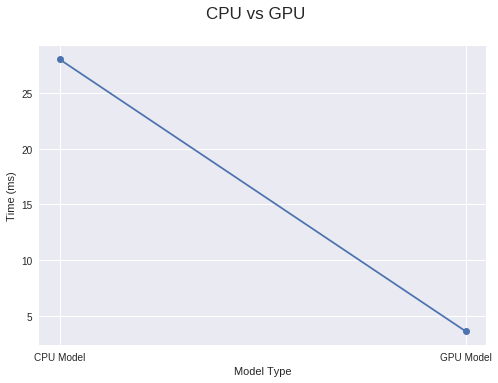

In [0]:
fig, ax = plt.subplots(1, 1)
ax.plot(["a", "b"], [28, 3.61], "-o")
ax.set_xticklabels(["CPU Model", "GPU Model"])
fig.suptitle("CPU vs GPU", fontsize=17)
ax.set_ylabel("Time (ms)")
ax.set_xlabel("Model Type")

# 5. How to select and work on GPU(s) if you have multiple of them?

In [0]:
# Sadly we only have one GPU here, so we will look into the dynamics with that GPU only.
cuda0 = torch.device('cuda:0')

x = torch.Tensor([1., 2.]).to(cuda0)
x

tensor([1., 2.], device='cuda:0')

In [0]:
# To change the default Device:
torch.cuda.set_device(0) # '0' is the Id of device

In [0]:
y = torch.Tensor([3., 4.]).to(cuda0)
z = x + y
z # This tensor is stored on the same device as x and y

tensor([4., 6.], device='cuda:0')

# 6. Data Parallelism?

In [0]:
# Again we only have one GPU, so we will only use that to see into Dynamics
module =  nn.Sequential(
         nn.Linear(20, 20),
         nn.ReLU(),
         nn.Linear(20, 4),
         nn.Softmax()
).cuda()

inp = torch.ones((30, 20)).cuda()

In [0]:
# Replicate module to devices in device_ids
replicas = nn.parallel.replicate(module, [0])

# Distribute input to devices in device_ids
inputs = nn.parallel.scatter(inp, [0])

# Apply the models to corresponding inputs
outputs = nn.parallel.parallel_apply(replicas, inputs)

# Gather result from all devices to output_device
result = nn.parallel.gather(outputs, 0)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [0]:
result.shape # Output from module

torch.Size([30, 4])

In [0]:
# Or we could have done:
model = nn.DataParallel(model, device_ids=[0])
result = model(inp)
result.shape

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([30, 4])